In [1]:
%load_ext autoreload
%autoreload 2

import os
import itertools
import utils
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm

from utils import plot_domain, plot_measure, send_zero_transparent

print(os.getcwd())

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams["savefig.dpi"] = 140
plt.rcParams['text.usetex'] = True 

from typing import List

/home/manifold/Documents/pyprojects/mva-optimaltransport/project


# More marginals

## Setup

$\newcommand{\NN}{\mathbb N}$
$\newcommand{\RR}{\mathbb R}$
$\newcommand{\dif}{\mathrm{d}}$
$\renewcommand{\epsilon}{\varepsilon}$
$\renewcommand{\phi}{\varphi}$
$\newcommand{\suchthat}{\mathrm{s.t.}}$
$$
\DeclareMathOperator{\supp}{supp}
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\argmax}{argmax}
$$
$\newcommand{\bfR}{\mathbf R}$
$\newcommand{\bfP}{\mathbf P}$
$\DeclareMathOperator{\divg}{div}$
$\DeclareMathOperator{\supp}{supp}$
$\DeclareMathOperator{\KL}{KL}$
$\DeclareMathOperator{\prox}{prox}$

Number of grid points:  5151
Mask shape: (101, 51)


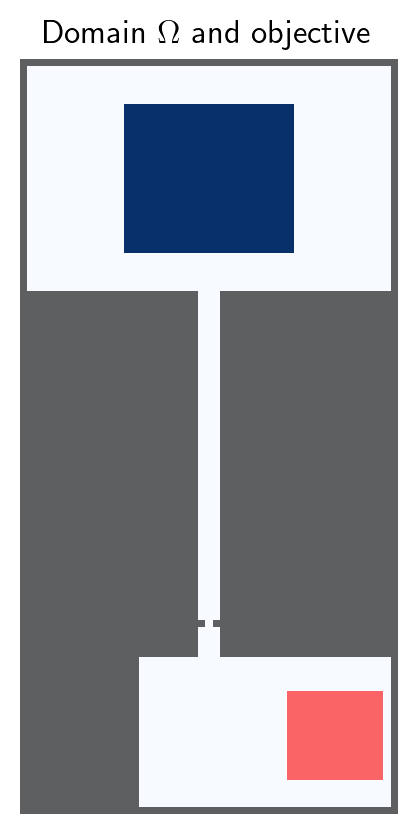

In [2]:
# Obstacle domain
from utils.rooms import room1, room2, room1_bis


nx = 51
xar = np.linspace(0, 1, nx)
dx = xar[1] - xar[0]
ny = 101
yar = np.linspace(0, 2, ny)
dy = yar[1] - yar[0]
xg, yg = np.meshgrid(xar, yar)
print("Number of grid points: ", xg.size)

extent = [0, xar.max(), 0, yar.max()]

IMAGE_DIR = "images/multimarg_room2/"
os.makedirs(IMAGE_DIR, exist_ok=True)

def setup1():
    rho_0 = (np.abs(xg - 0.24) <= 0.14) & (np.abs(yg - .86) <= 0.1)
    rho_0 = rho_0.astype(np.float64)
    rho_0 /= rho_0.sum()  # normalize the density
    mask = room1(xg, yg)
    exit_mask = (np.abs(xg - .8) <= 0.08) & (np.abs(yg - .14) <= 0.08)
    return rho_0, mask, exit_mask

def setup2():
    rho_0 = (np.abs(xg - 0.5) <= 0.22) & (np.abs(yg - 1.7) <= 0.2)
    rho_0 = rho_0.astype(np.float64)
    rho_0 /= rho_0.sum()  # normalize the density
    mask = room2(xg, yg)
    exit_mask = (np.abs(xg - .84) <= 0.12) & (np.abs(yg - .41) <= 0.24)
    return rho_0, mask, exit_mask

rho_0, mask, exit_mask = setup2()

domain_img = np.zeros((ny, nx, 4))
domain_img[mask, 3] = 1.

# Exit (target)

exit_layer = np.zeros((ny, nx, 4))
exit_layer[exit_mask, 0] = 1.
exit_layer[exit_mask, 3] = 1.

# Plot
fig = plt.figure()
plot_domain(domain_img, extent=extent)
plot_measure(rho_0, extent=extent)
plot_domain(exit_layer, alpha=.6)
plt.title("Domain $\\Omega$ and objective")
plt.axis('image')
plt.axis('off');

In [3]:
fig.savefig(IMAGE_DIR+"room_setup.pdf", bbox_inches='tight')

In [4]:
from fastsweeper import fast_sweep

# Use a HJ potential
speed_field = np.ones((ny, nx))
speed_field[mask] = 1e3  # "Kill" walking through the obstacles

sweep_iters = 140

potential_new_ = fast_sweep(speed_field, dx, exit_mask,
                            sweep_iters)
beta = 1.
potential_new_ = potential_new_ ** beta

In [5]:
dx == dy

True

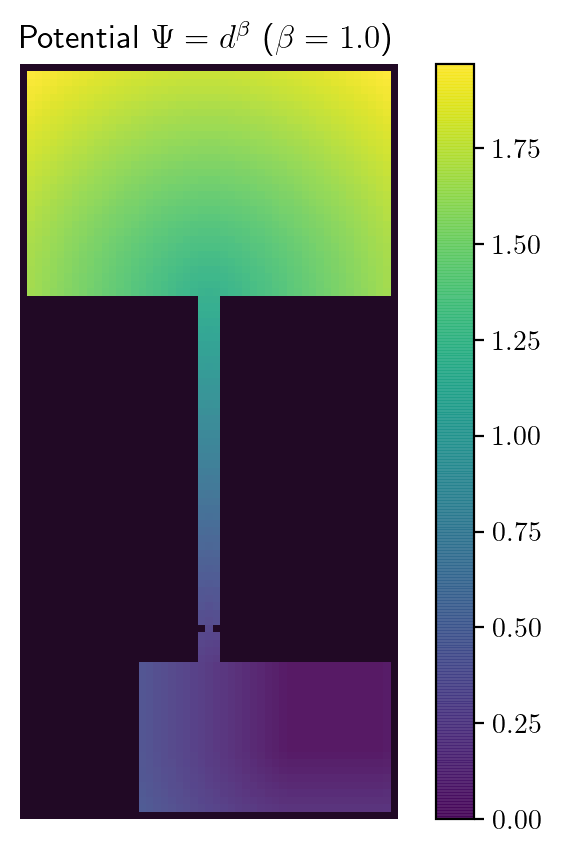

In [6]:
alphm = .9

fig = plt.figure()
ax = fig.add_subplot()
#ax.contourf((1-mask)*potential_new_, alpha=alphm, levels=40)
im_ = plot_measure((1-mask) * potential_new_,
                   extent=extent, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img, extent=extent)
#plot_domain(exit_layer, alpha=.3)

ax.set_title("Potential $\\Psi = d^\\beta$ ($\\beta=%.1f$)" 
             % beta)
#ax.set_aspect('auto')
fig.colorbar(im_)
plt.axis('off');

In [7]:
fig.savefig(IMAGE_DIR+"room_potential.pdf", bbox_inches='tight')

## Computation

In [8]:
from scipy.stats import norm
from scipy.spatial import distance

import numba

The full transport problem is
$$
    \inf_\gamma \epsilon H(\gamma, \bfR) + h\sum_{k=1}^N F(\rho_k) + G(\rho_N)
$$
under the constraints $P^k_\#\gamma = \rho_k$.

In [9]:
# x-direction kernel
cost_mat1 = distance.cdist(
    xar[:, None], xar[:, None])  # distance between 1st-coordinates
cost_mat2 = distance.cdist(
    yar[:, None], yar[:, None])  # distance between 1st-coordinates

In [10]:
from contraction import FactoredKernel, KernelOp

N_t = 50
tmax = 10.
dt = tmax / N_t  # timestep

sigma = 0.1
epsilon = sigma ** 2
print("Epsilon:", epsilon)
## New epsilon-kernel
K1_eps = norm.pdf(cost_mat1, scale=(sigma * dt ** .5))
K2_eps = norm.pdf(cost_mat2, scale=(sigma * dt ** .5))

class MyKernel(KernelOp):
    def call(self, x):
        return np.dot(K2_eps @ x, K1_eps)
K_eps_op = FactoredKernel(K1_eps, K2_eps)

Epsilon: 0.010000000000000002


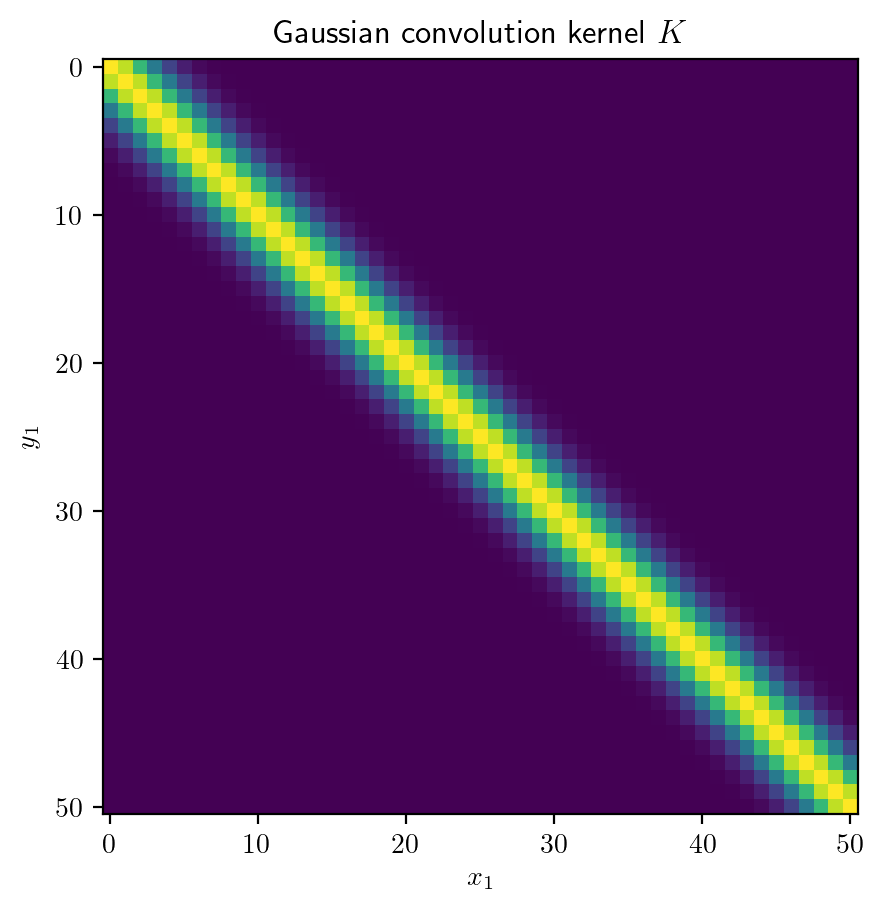

In [11]:
plt.imshow(K1_eps, interpolation='none')
plt.title("Gaussian convolution kernel $K$")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

The kernel is
$$
    \bfP_{i,j} = P_{h\epsilon}(x_j - x_i).
$$

Let's write the full Sinkhorn algorithm:

In [12]:
congest_max = 1.2 * rho_0.max()
print("Max congestion:", congest_max)

Max congestion: 0.002608695652173913


In [13]:
@numba.njit
def prox_operator(mes, mask, congest_max, psi):
    r"""Proximal operator"""
    return np.minimum(mes * np.exp(-psi/epsilon), congest_max) * (1-mask)


tau = 1e-16

## Redefine using the Cython module
def multi_sinkhorn(a_s: List[np.ndarray], op):
    """Multimarginal sinkhorn"""
    n_marg = len(a_s)  # no. of marginals
    conv = compute_message(a_s, 0, op)
    a_s[0] = rho_0 / (conv+tau)
    
    for k in range(1, n_marg-1):
        conv = compute_message(a_s, k, op)
        numer = prox_operator(conv, mask, congest_max, 0.)
        a_s[k] = numer / (conv+tau)
    
    conv = compute_message(a_s, n_marg-1, op)
    numer = prox_operator(conv, mask, congest_max, potential_new_)
    a_s[n_marg - 1] = numer / (conv+tau)

We get the marginals from
$$
    \rho_k^* = a_k^* \odot \mathbf{R}[(a^*_j)_{j\neq k}]
$$

In [14]:
from contraction import compute_message, compute_marginals

In [15]:
a_s = [
    np.ones((ny, nx)) for _ in range(N_t)
]

In [16]:
num_iters = 60
for n in range(num_iters):
    print("n:", n, end='\r')
    multi_sinkhorn(a_s, K_eps_op)

In [17]:
# Now compute the marginals from the potentials
marginals = compute_marginals(a_s, K_eps_op)

Text(0, 0.5, '$\\mu_t$')

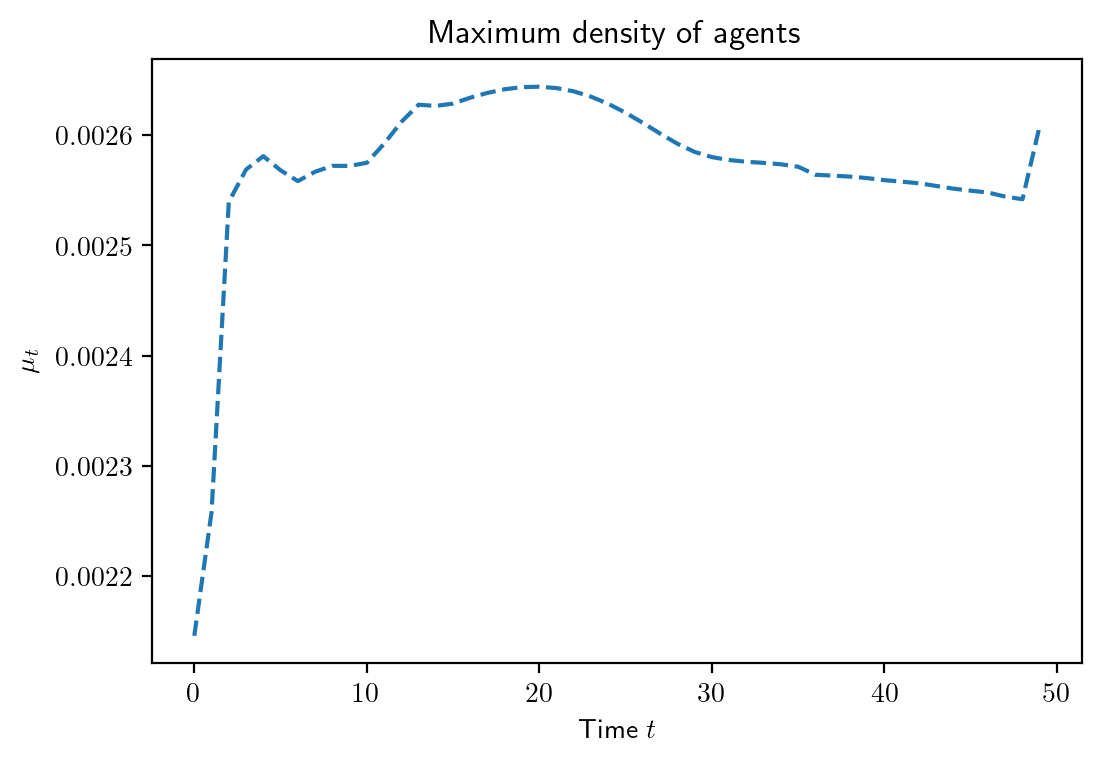

In [18]:
max_densities = []
for t, mu in enumerate(marginals):
    max_densities.append(mu.max())
    #print("Time %d: max density %.3e" % (t, mu.max()))
fig = plt.figure(figsize=(6,4))
plt.plot(max_densities, ls='--')
plt.title("Maximum density of agents")
plt.xlabel("Time $t$")
plt.ylabel("$\\mu_t$")

In [19]:
steps_to_plot = [4*t for t in range(N_t//4)]
steps_to_plot.append(N_t-1)
print(steps_to_plot)
print(len(steps_to_plot))
steps_to_plot

ncols = 4
nrows = len(steps_to_plot) // ncols
print("ncols:", ncols, "nrows:", nrows)

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 49]
13
ncols: 4 nrows: 3


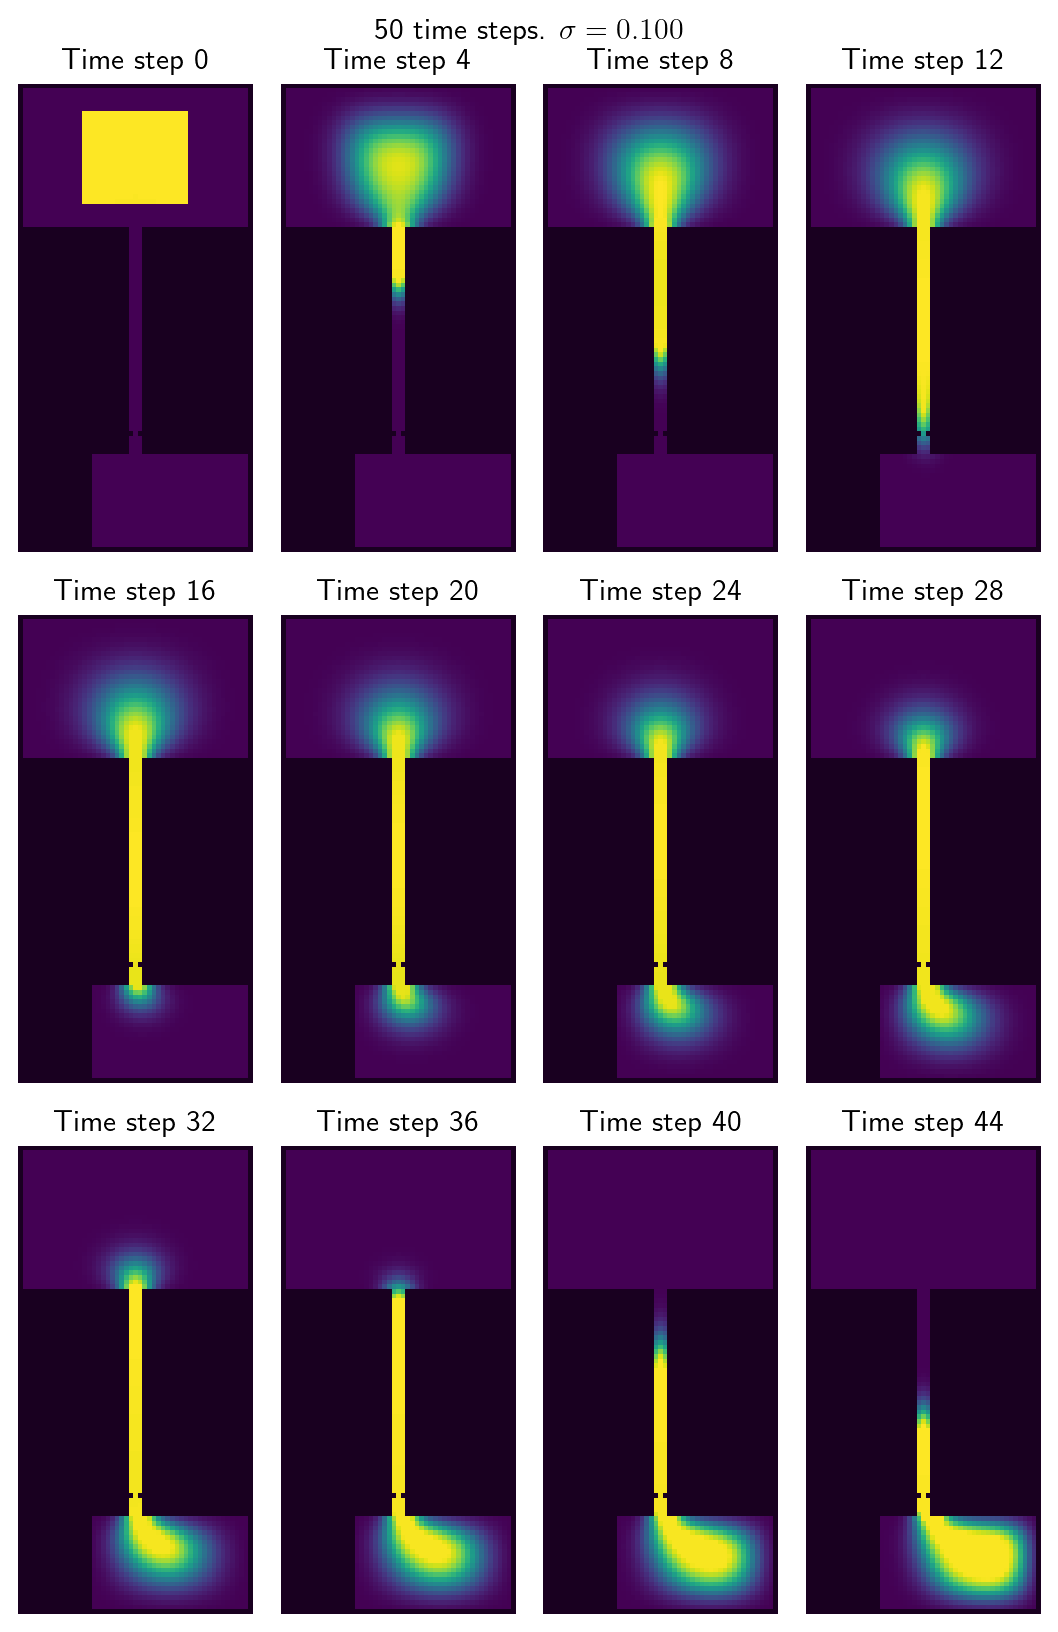

In [33]:
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 9), dpi=90)
axes = axes.ravel()



for i, t in enumerate(steps_to_plot):
    if i < len(axes):
        ax = axes[i]
        t = steps_to_plot[i]
        mu = marginals[t]
        plot_domain(domain_img, cax=ax, extent=extent)
        plot_measure(mu, cax=ax, extent=extent, cmap=cm.viridis)
        ax.axis('off')
        ax.set_title("Time step %d" % t)

fig.suptitle("%d time steps. $\\sigma=%.3f$" % (N_t, sigma), y=1.002)
fig.tight_layout();

In [27]:
fig.savefig(IMAGE_DIR+'multimarg_transport.pdf', bbox_inches='tight')